In [3]:
!pip install scikit-learn

In [5]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/a4/7d/f1c30a92854540bf789e9cd5dde7ef49bbe63f855b85a2e6b3db8135c591/opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB 653.6 kB/s eta 0:01:01
   -- ------------------------------------- 2.6/39.5 MB 28.1 MB/s eta 0:00:02
   --- ------------------------------------ 3.4/39.5 MB 24.1 MB/s eta 0:00:02
   --- ------------------------------------ 3.9/39.5 MB 20.6 MB/s eta 0:00:02
   ---- ----------------------------------- 4.3/39.5 MB 18.2 MB/s eta 0:00:02
   ---- ----------------------------------- 4.7/39.5 MB 16.7 MB/s eta 0:00:03
   ----- ---------------------------------- 5.1/39.5 MB 15.6 MB/s eta 0:00:03
   ----- ---------------------------------- 5.6/39.5 MB 14.9 MB/s eta 0:00:03
   ------ --------------------------------- 6.1/39.5 MB 14.4 MB/s eta 0:00:03
   --

In [35]:
import cv2
import numpy as np
import pandas as pd
import networkx as nx
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import Frame


In [7]:
# 读取图像中的比例尺信息（自动估算像素到 µm 转换率）
def estimate_pixel_to_um(image_path):
    default_pixel_to_um = 0.01
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"无法加载图像: {image_path}")
    height, width, _ = img.shape
    roi = img[-50:, :, 0]
    _, binary = cv2.threshold(roi, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        scale_bar_length_px = cv2.boundingRect(largest_contour)[2]
        scale_bar_length_um = 10
        return scale_bar_length_um / scale_bar_length_px
    return default_pixel_to_um

In [8]:
# 使用 Otsu + 形态学处理进行图像分割
def segment_image_otsu(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"图像未能正确加载，请检查文件路径或格式: {image_path}")
    
    # Otsu 阈值法
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 形态学操作 - 去除噪声
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    binary = cv2.dilate(binary, kernel, iterations=1)
    
    # Canny 边缘检测
    edges = cv2.Canny(binary, 100, 200)
    return edges, binary

In [9]:
# 预处理图像并检测颗粒
def detect_particles(image_path, pixel_to_um):
    edges, binary = segment_image_otsu(image_path)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    particle_data = []
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            area_px = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * area_px / (perimeter ** 2) if perimeter > 0 else 0
            area_um = area_px * (pixel_to_um ** 2)
            centroids.append((cx, cy))
            particle_data.append((cx, cy, area_um, circularity))
    return centroids, particle_data, binary

In [20]:
import math  # 如果尚未引用 math 模組，請加上這一行

def detect_tpb_points_improved(centroids, pixel_to_um, threshold_um=0.5, angle_threshold=30):
    """
    改進版的 TPB 檢測函式：
      - 根據距離閥值建立鄰近關係。
      - 對每個與至少兩個鄰居連接的節點，計算從該節點指向每個鄰居的向量，
        並計算所有向量之間的夾角，以最小夾角作為可信度依據。
    
    參數：
      centroids: list of (x, y) 粒子質心
      pixel_to_um: 每個像素代表多少 µm
      threshold_um: 鄰近距離閥值，預設 0.5 µm
      angle_threshold: 角度過濾閥值，低於此值則可信度為 0（單位：度）
    
    回傳：
      tpb_points: 檢測到的 TPB 點列表
      confidence_scores: 每個 TPB 點對應的可信度分數（0～1）
    """
    threshold_px = threshold_um / pixel_to_um
    G = nx.Graph()
    
    # 建立鄰近關係，僅比較一次 (i < j)
    for i, (x1, y1) in enumerate(centroids):
        for j, (x2, y2) in enumerate(centroids):
            if i < j:
                distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                if distance < threshold_px:
                    G.add_edge(i, j)
    
    tpb_points = []
    confidence_scores = []
    for node in G.nodes:
        neighbors = list(G[node])
        if len(neighbors) >= 2:
            x0, y0 = centroids[node]
            vectors = []
            for n in neighbors:
                xn, yn = centroids[n]
                dx, dy = xn - x0, yn - y0
                norm = math.hypot(dx, dy)
                if norm > 0:
                    vectors.append((dx / norm, dy / norm))
            if len(vectors) < 2:
                continue
            
            angles = []
            for i in range(len(vectors)):
                for j in range(i+1, len(vectors)):
                    dot = np.clip(vectors[i][0] * vectors[j][0] + vectors[i][1] * vectors[j][1], -1.0, 1.0)
                    angle = math.degrees(math.acos(dot))
                    angles.append(angle)
            
            if angles:
                min_angle = min(angles)
                if min_angle < angle_threshold:
                    conf = 0.0
                else:
                    conf = min_angle / 90.0
                    conf = max(0.0, min(conf, 1.0))
                
                tpb_points.append(centroids[node])
                confidence_scores.append(conf)
    
    return tpb_points, confidence_scores


In [11]:
# 可视化 TPB 结果
def visualize_tpb(image_path, centroids, tpb_points):
    img = cv2.imread(image_path)
    for (cx, cy) in centroids:
        cv2.circle(img, (cx, cy), 3, (0, 255, 0), -1)  # 绿色标记颗粒
    for (tx, ty) in tpb_points:
        cv2.circle(img, (tx, ty), 3, (0, 0, 255), -1)  # 红色标记 TPB
    output_path = "tpb_output.png"
    cv2.imwrite(output_path, img)
    return output_path

In [12]:
# 计算 TPB 密度
def calculate_tpb_density(tpb_points, image_shape, pixel_to_um):
    img_area_um2 = (image_shape[0] * pixel_to_um) * (image_shape[1] * pixel_to_um)
    unit_count = img_area_um2 / 10
    tpb_density = len(tpb_points) / unit_count if unit_count > 0 else 0
    return tpb_density

In [18]:
# 保存数据到CSV
def save_tpb_data (particle_data, tpb_points):
    df = pd.DataFrame(particle_data, columns=["Centroid_X", "Centroid_Y", "Area_um2", "Circularity"])
    df_tpb = pd.DataFrame(tpb_points, columns=["TPB_X", "TPB_Y"])
    df.to_csv("particles.csv", index=False)
    df_tpb.to_csv("tpb_points.csv", index=False)

In [29]:
def plot_confidence_histogram(confidence_scores):
    """
    绘制候选 TPB 点可信度分布直方图，并返回 matplotlib 的 Figure 对象。
    
    参数：
      confidence_scores: list, 每个候选 TPB 点的可信度分数，值介于 0 到 1 之间。
      
    返回：
      fig: matplotlib.figure.Figure 对象，可以用于进一步嵌入到 GUI 中显示。
    """
    import matplotlib.pyplot as plt  # 如果你还没有导入 matplotlib，请确保这里导入
    # 创建一个大小为 4x3 英寸的图形
    fig, ax = plt.subplots(figsize=(4, 3))
    # 绘制直方图，设定 10 个箱子，范围为 0 到 1，边框颜色为黑色
    ax.hist(confidence_scores, bins=10, range=(0, 1), edgecolor='black')
    # 设置图形标题和坐标轴标签
    ax.set_title("TPB 点可信度分布")
    ax.set_xlabel("可信度")
    ax.set_ylabel("点的数量")
    # 设置 x 轴刻度
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    return fig


C:\Users\User\AppData\Local\Temp\ipykernel_11028\3353405935.py:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  default_img = default_img.resize((800, 600), Image.ANTIALIAS)


Loading image: D:/User/Downloads/Telegram Desktop/41918_2019_43_Fig4_HTML (3).jpg


C:\Users\User\AppData\Local\Temp\ipykernel_11028\3353405935.py:147: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  proc_img = Image.open("binarized.png").resize((500, 500), Image.ANTIALIAS)
C:\Users\User\AppData\Local\Temp\ipykernel_11028\3353405935.py:150: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  orig_img = Image.open(filepath).resize((500, 500), Image.ANTIALIAS)


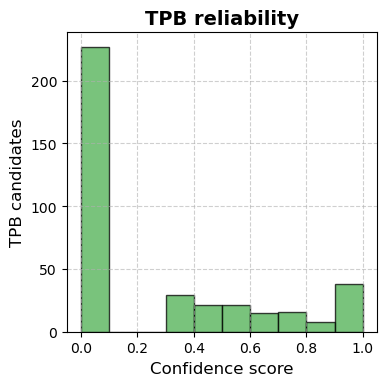

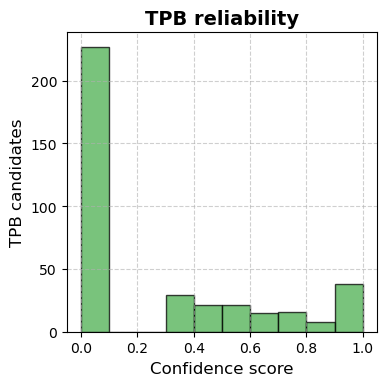

In [73]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import cv2
import numpy as np

# Global variables for passing data between pages
last_result_str = ""
last_processed_img_tk = None
last_original_img_tk = None
last_conf_scores = None

# ---------------- Page Switching Functions ----------------

def show_page1():
    """Page 1: Only displays a default cover and an 'Upload Image' button."""
    for widget in root.winfo_children():
        widget.destroy()
    initial_frame = tk.Frame(root)
    initial_frame.pack(expand=True, fill="both")
    
    try:
        default_img = Image.open("default_cover.jpg")
        default_img = default_img.resize((800, 600), Image.ANTIALIAS)
        default_img_tk = ImageTk.PhotoImage(default_img)
    except Exception as e:
        print("Error loading default cover image:", e)
        default_img_tk = None

    cover_label = tk.Label(initial_frame)
    if default_img_tk is not None:
        cover_label.config(image=default_img_tk)
        cover_label.image = default_img_tk
    else:
        cover_label.config(text="Waiting for an image", font=("Arial", 24))
    cover_label.pack(expand=True, fill="both")
    
    upload_btn_initial = tk.Button(initial_frame, text="Upload Image", font=("Arial", 16),
                                   command=lambda: upload_image())
    upload_btn_initial.pack(side="bottom", pady=20)

def show_page2(result_str, orig_img_tk, proc_img_tk, conf_scores):
    """Page 2: Displays a title at the top and, in one row, three images:
       left - original image; middle - processed image; right - histogram.
       At the bottom, displays the analysis result and navigation buttons.
    """
    for widget in root.winfo_children():
        widget.destroy()
    
    # Title
    title_label = tk.Label(root, text="TPB Analysis Results", font=("Arial", 20, "bold"))
    title_label.pack(pady=10)
    
    # Container for three images in one row
    images_frame = tk.Frame(root)
    images_frame.pack(expand=True, pady=20)
    
    # Left: Original image (fixed 400x400 with border)
    left_frame = tk.Frame(images_frame, width=400, height=400, bd=2, relief="solid")
    left_frame.pack(side="left", padx=10, pady=10)
    left_frame.pack_propagate(False)
    orig_label = tk.Label(left_frame, image=orig_img_tk)
    orig_label.image = orig_img_tk
    orig_label.pack(expand=True, fill="both")
    
    # Middle: Processed image (fixed 400x400 with border)
    middle_frame = tk.Frame(images_frame, width=400, height=400, bd=2, relief="solid")
    middle_frame.pack(side="left", padx=10, pady=10)
    middle_frame.pack_propagate(False)
    proc_label = tk.Label(middle_frame, image=proc_img_tk)
    proc_label.image = proc_img_tk
    proc_label.pack(expand=True, fill="both")
    
    # Right: Histogram (fixed 400x400 with border)
    right_frame = tk.Frame(images_frame, width=400, height=400, bd=2, relief="solid")
    right_frame.pack(side="left", padx=10, pady=10)
    right_frame.pack_propagate(False)
    fig = plot_confidence_histogram(conf_scores)
    hist_canvas = FigureCanvasTkAgg(fig, master=right_frame)
    hist_canvas.draw()
    hist_canvas.get_tk_widget().pack(expand=True, fill="both")
    
    # Bottom navigation area: display analysis result and navigation buttons
    nav_frame = tk.Frame(root)
    nav_frame.pack(fill="x", pady=10)
    result_label = tk.Label(nav_frame, text=result_str, font=("Arial", 14), justify="center")
    result_label.pack(pady=5)
    btn_frame = tk.Frame(nav_frame)
    btn_frame.pack()
    prev_btn = tk.Button(btn_frame, text="Previous Page", font=("Arial", 14), command=show_page1)
    prev_btn.pack(side="left", padx=10)
    next_btn = tk.Button(btn_frame, text="Next Page", font=("Arial", 14), command=show_page3)
    next_btn.pack(side="left", padx=10)

def show_page3():
    """Page 3: Displays two placeholder frames (fixed size) and a 'Previous Page' button."""
    for widget in root.winfo_children():
        widget.destroy()
    third_frame = tk.Frame(root)
    third_frame.pack(expand=True, fill="both", padx=20, pady=20)
    
    left_third = tk.Frame(third_frame, bd=2, relief="solid", width=400, height=400)
    left_third.pack(side="left", expand=True, fill="both", padx=10, pady=10)
    left_third.pack_propagate(False)
    left_label = tk.Label(left_third, text="Third Page Left Frame", font=("Arial", 16))
    left_label.pack(expand=True)
    
    right_third = tk.Frame(third_frame, bd=2, relief="solid", width=400, height=400)
    right_third.pack(side="left", expand=True, fill="both", padx=10, pady=10)
    right_third.pack_propagate(False)
    right_label = tk.Label(right_third, text="Third Page Right Frame", font=("Arial", 16))
    right_label.pack(expand=True)
    
    nav_frame = tk.Frame(root)
    nav_frame.pack(fill="x", pady=10)
    prev_btn = tk.Button(nav_frame, text="Previous Page", font=("Arial", 14),
                         command=lambda: show_page2(last_result_str, last_original_img_tk, last_processed_img_tk, last_conf_scores))
    prev_btn.pack(pady=5)

# ---------------- Upload Image Processing Function ----------------

def upload_image():
    global last_result_str, last_processed_img_tk, last_original_img_tk, last_conf_scores
    filepath = filedialog.askopenfilename()
    if not filepath:
        return
    try:
        print(f"Loading image: {filepath}")
        pixel_to_um = estimate_pixel_to_um(filepath)
        centroids, particle_data, binary = detect_particles(filepath, pixel_to_um)
        tpb_points, conf_scores = detect_tpb_points_improved(centroids, pixel_to_um)
        avg_confidence = sum(conf_scores) / len(conf_scores) if conf_scores else 0
        output_path = visualize_tpb(filepath, centroids, tpb_points)
        tpb_density = calculate_tpb_density(tpb_points, binary.shape, pixel_to_um)
        save_tpb_data(particle_data, tpb_points)
        
        result_str = (f"TPB Density: {tpb_density:.2f} TPB/10µm²    "
                      f"Detected {len(tpb_points)} TPB    "
                      f"Avg. Confidence: {avg_confidence*100:.1f}%")
        
        # Convert binary image to uint8 and save to avoid data type issues
        binary_uint8 = np.uint8(binary)
        cv2.imwrite("binarized.png", binary_uint8)
        
        # Processed image from binarized.png resized to 500x500
        proc_img = Image.open("binarized.png").resize((500, 500), Image.ANTIALIAS)
        proc_img_tk = ImageTk.PhotoImage(proc_img)
        # Original image from uploaded file resized to 500x500
        orig_img = Image.open(filepath).resize((500, 500), Image.ANTIALIAS)
        orig_img_tk = ImageTk.PhotoImage(orig_img)
        
        # Save global variables for page switching
        last_result_str = result_str
        last_processed_img_tk = proc_img_tk
        last_original_img_tk = orig_img_tk
        last_conf_scores = conf_scores
        
        # Switch to Page 2
        show_page2(result_str, orig_img_tk, proc_img_tk, conf_scores)
        
    except Exception as e:
        messagebox.showerror("Error", f"Error processing image: {str(e)}")
        print(f"Error processing image: {str(e)}")

# ---------------- Initialize Main Window ----------------

root = tk.Tk()
root.title("PEMFC TPB Recognition System")
root.geometry("1000x700")
show_page1()
root.mainloop()
